### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [4]:
batch_size = 4 #受限于贫穷，3是极限了
learning_rate = 0.0000195
target_size = 256
epochs = 5

In [5]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [6]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [7]:
model = VGG16()

In [8]:
model.load_state_dict(torch.load("./model/MPFA_47.pth"), strict=False)

<All keys matched successfully>

In [9]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)
model.train()

VGG16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling3): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1,

In [10]:
for epoch in range(48, 54):
    criterion = EdgeHoldLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                weight_decay=0,
                                momentum=0.9)
    print("lr:{:.10f}".format(learning_rate))
    start_time = time.time()
    learning_rate = learning_rate - learning_rate * 0.1
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}".format(epoch, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")
    torch.save(model.state_dict(),"./model/MPFA_{}.pth".format(epoch))

lr:0.0000195000
Epoch:49 loss:0.4203837811946869 Batch:100/2639 acc:0.9266180396080017 pre:0.9399300217628479 recall:0.8906222581863403 F-measure:0.9266219735145569
Epoch:49 loss:0.4176151752471924 Batch:200/2639 acc:0.9247843623161316 pre:0.9407615661621094 recall:0.8934574127197266 F-measure:0.9281007051467896
Epoch:49 loss:0.4175248146057129 Batch:300/2639 acc:0.9238851070404053 pre:0.9420782923698425 recall:0.8946753144264221 F-measure:0.9294194579124451
Epoch:49 loss:0.4242340922355652 Batch:400/2639 acc:0.9242188930511475 pre:0.9404240846633911 recall:0.8953675031661987 F-measure:0.928300142288208
Epoch:49 loss:0.4149221181869507 Batch:500/2639 acc:0.9246799349784851 pre:0.9416536688804626 recall:0.897720217704773 F-measure:0.9298737645149231
Epoch:49 loss:0.4270697236061096 Batch:600/2639 acc:0.9242860078811646 pre:0.9410904049873352 recall:0.8956923484802246 F-measure:0.9288991689682007
Epoch:49 loss:0.4232639670372009 Batch:700/2639 acc:0.9239693880081177 pre:0.941073358058929

lr:0.0000157950
Epoch:51 loss:0.4205024242401123 Batch:100/2639 acc:0.9261930584907532 pre:0.9432221055030823 recall:0.8944433927536011 F-measure:0.9299417734146118
Epoch:51 loss:0.40687376260757446 Batch:200/2639 acc:0.9267974495887756 pre:0.9395769834518433 recall:0.8996906876564026 F-measure:0.9286297559738159
Epoch:51 loss:0.435348242521286 Batch:300/2639 acc:0.9239311218261719 pre:0.9335426092147827 recall:0.897578239440918 F-measure:0.9232691526412964
Epoch:51 loss:0.420992910861969 Batch:400/2639 acc:0.9247223734855652 pre:0.9361738562583923 recall:0.8971518278121948 F-measure:0.9250726699829102
Epoch:51 loss:0.42605331540107727 Batch:500/2639 acc:0.9244182109832764 pre:0.9376375079154968 recall:0.8966681361198425 F-measure:0.9259787201881409
Epoch:51 loss:0.4167821407318115 Batch:600/2639 acc:0.9249012470245361 pre:0.9365196824073792 recall:0.8979038596153259 F-measure:0.925311803817749
Epoch:51 loss:0.42542895674705505 Batch:700/2639 acc:0.9241401553153992 pre:0.93715304136276

lr:0.0000127939
Epoch:53 loss:0.41560882329940796 Batch:100/2639 acc:0.9221860766410828 pre:0.9281207919120789 recall:0.8999021053314209 F-measure:0.9195845723152161
Epoch:53 loss:0.42840397357940674 Batch:200/2639 acc:0.9240082502365112 pre:0.933439314365387 recall:0.899154007434845 F-measure:0.9236623048782349
Epoch:53 loss:0.42876073718070984 Batch:300/2639 acc:0.9232341647148132 pre:0.934913158416748 recall:0.8989033102989197 F-measure:0.9246559143066406
Epoch:53 loss:0.42104679346084595 Batch:400/2639 acc:0.9226519465446472 pre:0.9363380074501038 recall:0.8939612507820129 F-measure:0.9242680668830872
Epoch:53 loss:0.426119327545166 Batch:500/2639 acc:0.9224821925163269 pre:0.9366039037704468 recall:0.8942388296127319 F-measure:0.9245848059654236
Epoch:53 loss:0.4160785377025604 Batch:600/2639 acc:0.9234611392021179 pre:0.9372223019599915 recall:0.8949328660964966 F-measure:0.9253478050231934
Epoch:53 loss:0.41077643632888794 Batch:700/2639 acc:0.9243919849395752 pre:0.939291477203

In [11]:
# torch.save(model.state_dict(),"./model/MPFA_47.pth")

In [12]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [13]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [14]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [15]:
msk.shape

torch.Size([256, 256, 1])

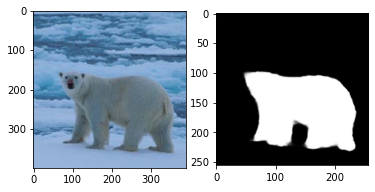

In [16]:
img = getInput("./image/1.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

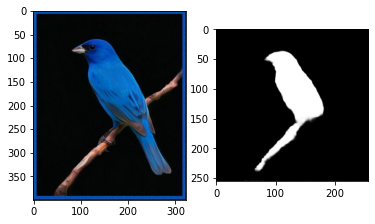

In [17]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

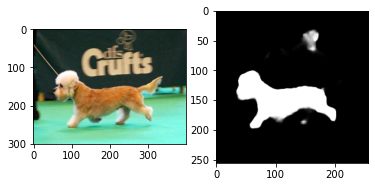

In [18]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()